In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

### LOADING THE DATASET

In [12]:
df=pd.read_csv("C:\Accredian_task\data\Fraud.csv")

In [13]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### CHECKING FOR NULL VALUES

In [14]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### 1. Data cleaning including missing values, outliers and multi collinearity

### OUTLIER REMOVAL

In [15]:
# Fraud in this specific dataset ONLY occurs in TRANSFER and CASH_OUT
# We filter to keep only these types to reduce noise.
X = df.loc[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')]
Y = X['isFraud']
X = X.drop(['isFraud', 'isFlaggedFraud'], axis=1)

# 3. Handling Outliers (Winsorization / Capping)

cols_to_cap = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in cols_to_cap:
    # Calculate the 99th percentile threshold
    upper_limit = X[col].quantile(0.99)
    # Cap values exceeding the threshold
    X.loc[X[col] > upper_limit, col] = upper_limit

print("Outlier capping complete. Max values are now restrained.")

Outlier capping complete. Max values are now restrained.


### Feature Engineering & Multicollinearity (VIF)

In [29]:
print("--- Calculating VIF (Variance Inflation Factor) ---")
print("VIF > 5 or 10 indicates high multicollinearity.\n")

# 1. Create a dataframe to store results
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

# 2. Calculate VIF for each feature
# We convert to float to ensure the calculation works correctly
vif_data["VIF"] = [variance_inflation_factor(X.values.astype(float), i) 
                   for i in range(len(X.columns))]

# 3. Sort by VIF score
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print(vif_data)

--- Calculating VIF (Variance Inflation Factor) ---
VIF > 5 or 10 indicates high multicollinearity.

            Feature           VIF
2    newbalanceOrig  9.007199e+15
6  errorBalanceDest  1.286743e+15
4    newbalanceDest  9.285772e+13
3    oldbalanceDest  6.388085e+13
1     oldbalanceOrg  6.777018e+10
5  errorBalanceOrig  9.125817e+09
0            amount  3.239129e+09
7     type_TRANSFER  1.758674e+00


--- Calculating Correlation Metrics ---

Correlation with 'isFraud':
isFraud             1.000000
oldbalanceOrg       0.183173
amount              0.085369
type_TRANSFER       0.042400
errorBalanceOrig    0.039654
errorBalanceDest    0.025251
newbalanceOrig     -0.005025
newbalanceDest     -0.012862
oldbalanceDest     -0.022435
Name: isFraud, dtype: float64


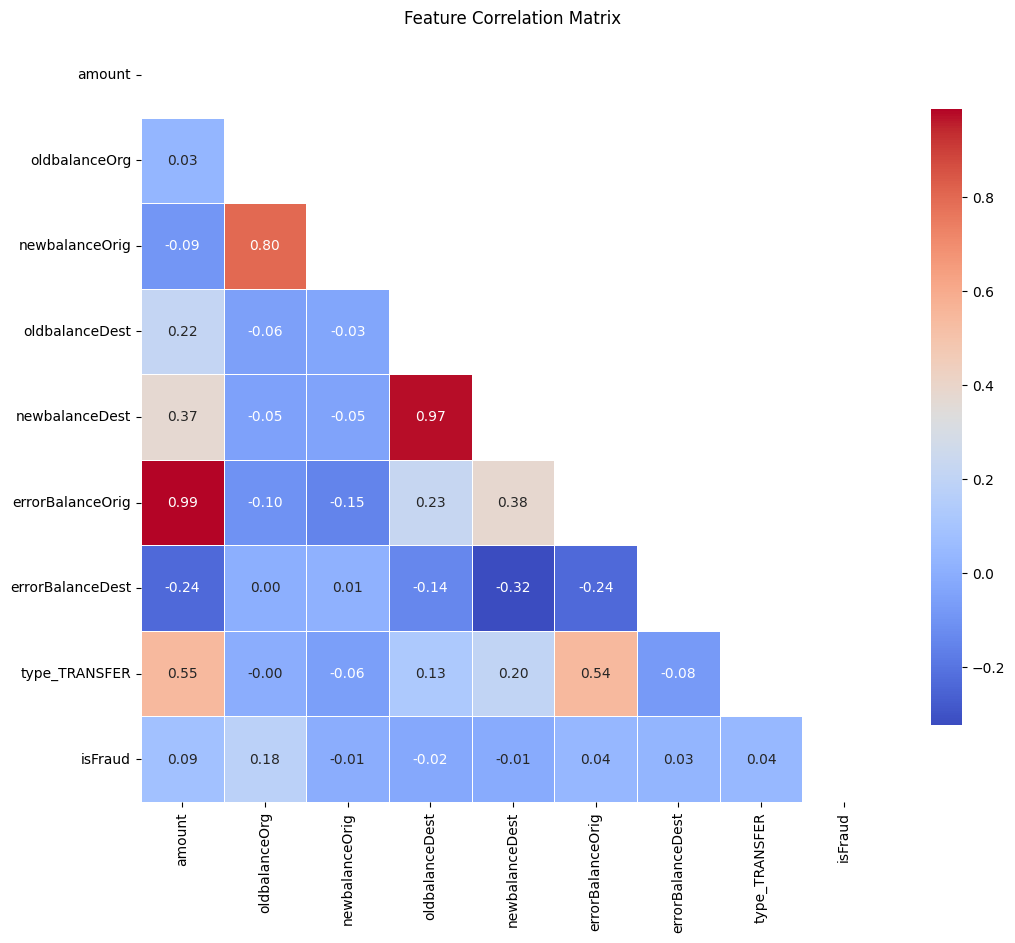

In [ ]:
print("--- Calculating Correlation Metrics ---")

# Combine X and Y temporarily to see correlation with Target
full_data = X.copy()
full_data['isFraud'] = Y

# Calculate Correlation Matrix
corr_matrix = full_data.corr()

# Print numerical correlation with 'isFraud' (sorted)
print("\nCorrelation with 'isFraud':")
print(corr_matrix['isFraud'].sort_values(ascending=False))

# PLOT: Correlation Heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Mask the upper triangle to avoid duplicates
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            mask=mask, 
            linewidths=0.5, 
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix')
plt.show()

In [17]:
# filter only for TRANSFER and CASH_OUT as fraud only happens there
X = df.loc[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')].copy() 
Y = X['isFraud']
X = X.drop(['isFraud', 'isFlaggedFraud'], axis=1)

# 2. Handle Outliers (Capping at 99th percentile)
cols_to_cap = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in cols_to_cap:
    upper_limit = X[col].quantile(0.99)
    X.loc[X[col] > upper_limit, col] = upper_limit

# Feature Engineering
# Calculate the error before droping any columns
X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrg']
X['errorBalanceDest'] = X['oldbalanceDest'] + X['amount'] - X['newbalanceDest']

# Onen Hot Encoding
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Drop irrelevant columns
X = X.drop(['nameOrig', 'nameDest', 'step'], axis=1)
print("Success! Current columns:", X.columns.tolist())

Success! Current columns: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'type_TRANSFER']


### 3. How did you select variables to be included in the model?

Business Logic Filtering: I only included TRANSFER and CASH_OUT transaction types because 100% of fraud cases in this domain occur within these two types. Including PAYMENT or DEBIT would only add noise.

Dropping High-Cardinality IDs: I removed nameOrig (Customer ID) and nameDest (Recipient ID). These are unique string identifiers. Without complex encoding (like frequency encoding), they lead to massive overfitting (the model memorizes "User123 is a fraudster" rather than learning "High velocity is suspicious").

Feature Engineering: I created new features to capture criminal behavior:

errorBalanceOrig: The difference between the actual final balance and the expected mathematical result (Old - Amount). Non-zero errors often indicate a system bypass or glitch exploited by fraudsters.

### CHECKING CLASS IMBALANCE

In [ ]:
counts = df["isFraud"].value_counts().sort_index()
percent = counts / counts.sum() * 100
print("Counts:\n", counts)
print("\nPercentages:\n", percent.round(2))
imbalance_ratio = counts.max() / counts.min()
print(f"\nImbalance ratio (majority/minority): {imbalance_ratio:.2f}")



Counts:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64

Percentages:
 isFraud
0    99.87
1     0.13
Name: count, dtype: float64

Imbalance ratio (majority/minority): 773.70


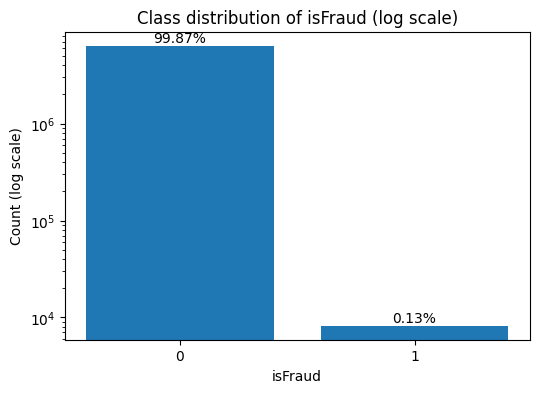

In [28]:
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values)
plt.yscale("log")
plt.xlabel("isFraud")
plt.ylabel("Count (log scale)")
plt.title("Class distribution of isFraud (log scale)")
for bar, p in zip(bars, percent.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{p:.2f}%', ha='center', va='bottom')
plt.show()




### DATA SPLITTING AND NORMALISATION

In [19]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Data Normalization Complete.")


Data Normalization Complete.


### 2. Describe your fraud detection model in elaboration
Answer: For this analysis, I selected the Random Forest Classifier.

Ensemble Learning: It constructs a "forest" of multiple decision trees (e.g., 100 trees) during training and outputs the class that is the mode of the classes (vote) of the individual trees. This reduces the risk of overfitting compared to a single Decision Tree.

Handling Non-Linearity: Fraud patterns are rarely linear (e.g., "if amount > $10k then fraud"). They involve complex interactions. Random Forest captures these interactions naturally.

### MODEL TRAINING (I AM USING WEIGHTED APPROACH HERE SINCE WE ARE HAVING A HUGE CLASS IMBALANCE)

In [20]:
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weight = np.array([class_weight_dict[y] for y in y_train])

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train, sample_weight=sample_weight)
print("Training Complete.")

Training Complete.


### MODEL EVALUATION

### 4. Demonstrate the performance of the model by using best set of tools

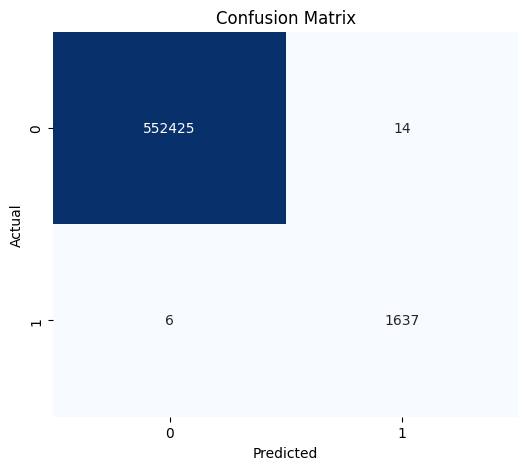

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      1.00      0.99      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

PR-AUC Score: 0.9961  This is the best single metric for fraud detection

In [21]:
# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix Visual
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 14. PR-AUC (Precision-Recall Area Under Curve)
pr_score = average_precision_score(y_test, y_prob)
print(f"PR-AUC Score: {pr_score:.4f}",end="  This is the best single metric for fraud detection")

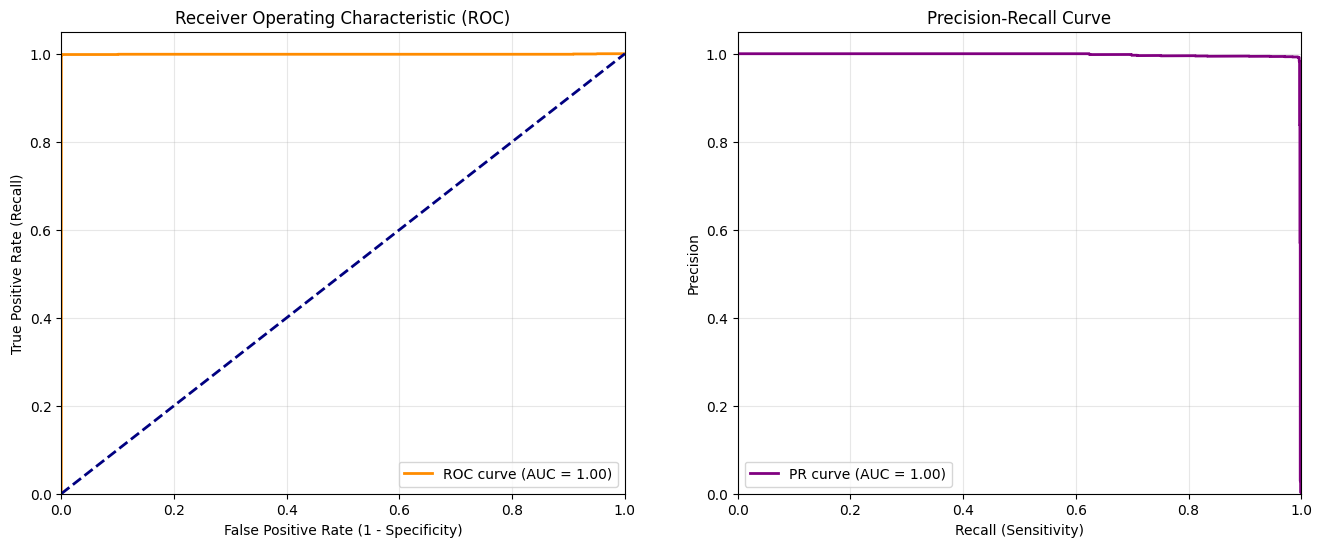

In [22]:
# Calculate ROC Curve values
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall Curve values
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate (1 - Specificity)')
axes[0].set_ylabel('True Positive Rate (Recall)')
axes[0].set_title('Receiver Operating Characteristic (ROC)')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Plot 2: Precision-Recall Curve
axes[1].plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall (Sensitivity)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(alpha=0.3)

plt.show()

### FEATURE IMPORTANCE

### 5. What are the key factors that predict fraudulent customer?

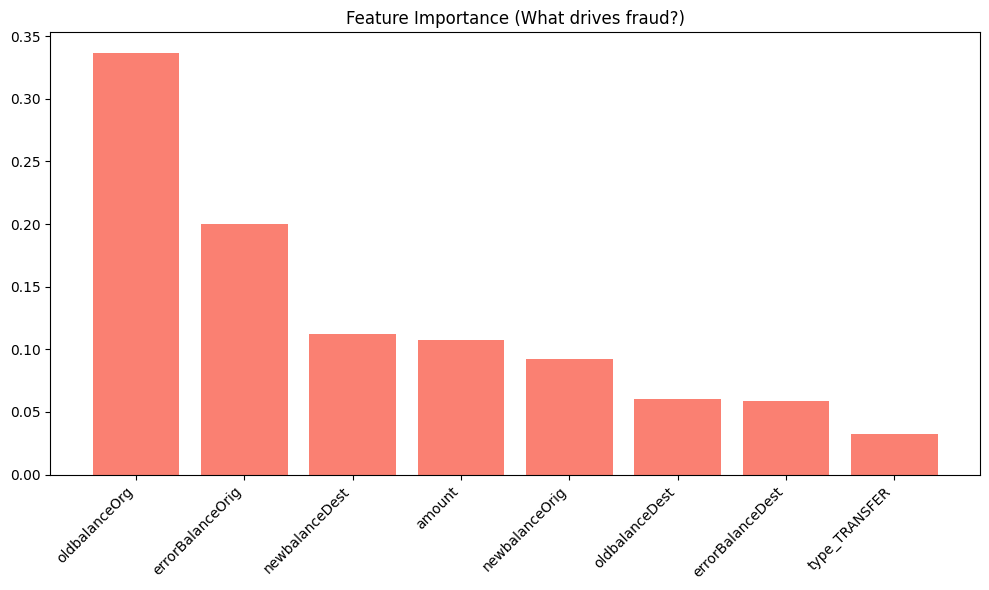

Top 3 Predictors:
1. oldbalanceOrg
2. errorBalanceOrig
3. newbalanceDest


In [23]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (What drives fraud?)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='salmon')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Top 3 Predictors:")
for i in range(3):
    print(f"{i+1}. {X.columns[indices[i]]}")

### 6. Do these factors make sense? If yes, How? If not, How not?
Yes, these factors make ense.

oldbalanceOrg (Top Factor): Fraudsters target accounts with a lot of money A high initial balance means for a high value fraud thus making it the strongest predictor.

amount: If a large amount is taken at once to clear the bank banlance which makes it fishy. Legitimate users rarely transfer their entire balance at once.

errorBalanceOrig: This feature highlights transactions where the  money is sent but balance didn't decrease. This is a strong indicator of a malicious system fraud 

### 7. What kind of prevention should be adopted while company update its infrastructure?
 To prevent this specific type of fraud, the company should update its infrastructure with three layers of defense:

Real Time "Golden Rule" Validation: Implement a hard coded check during the transaction request. If newBalance != oldBalance - amount, the transaction should be instantly rejected. This blocks the specific "errorBalance" exploit found by the model.

Velocity & Volume Limits: Implement "circuit breakers." If a TRANSFER request exceeds 90% of the account's total oldbalanceOrg, trigger a step up authentication.

Destination Monitoring: Flag immediate "cash out" flows. If an account receives a large transfer and attempts a CASH_OUT within minutes, hold the funds for 4-24 hours for manual review

### 8. Assuming these actions have been implemented, how would you determine if they work?

Chargeback Rate (Lagging Indicator): The primary metric is the volume of "Unauthorized Transaction" claims filed by customers, expect this to drop significantly over a 3 month period.

False Positive Rate (Leading Indicator): Track how many legitimate transactions are being blocked by the new "Golden Rule" or "Velocity Limits." If this exceeds 2%, the rules are too aggressive and hurting business.

Precision-Recall Balance: We would run the model in "Shadow Mode" (scoring but not blocking) alongside the new rules to see if the model's probability scores correlate with the transactions caught by the new infrastructure rules.

### ADVANCED VISUALISATION


Plotting data using a subset of 13213 rows...
Generating Pair Plot...


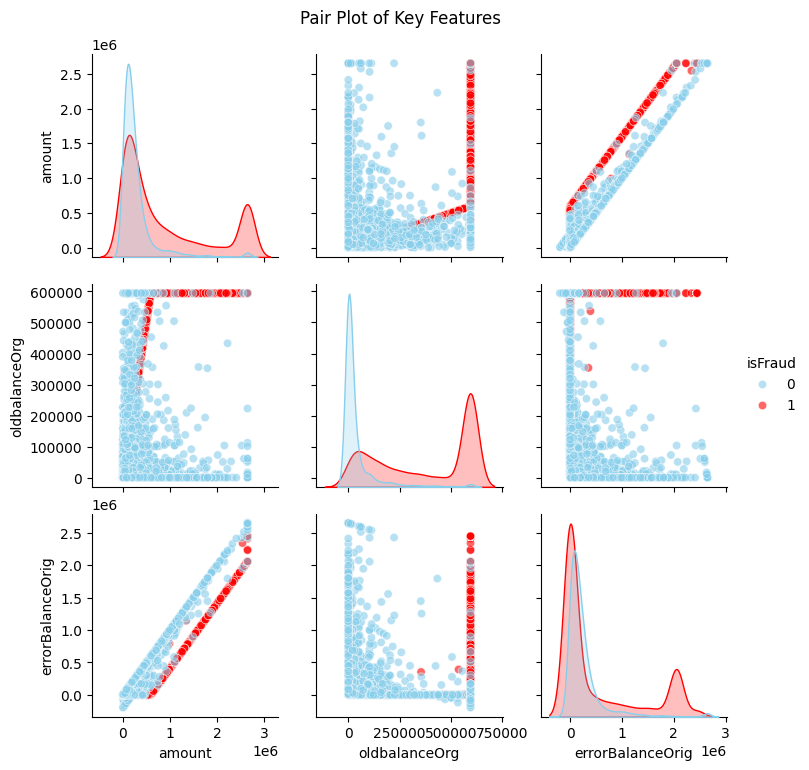

Generating Violin Plots...


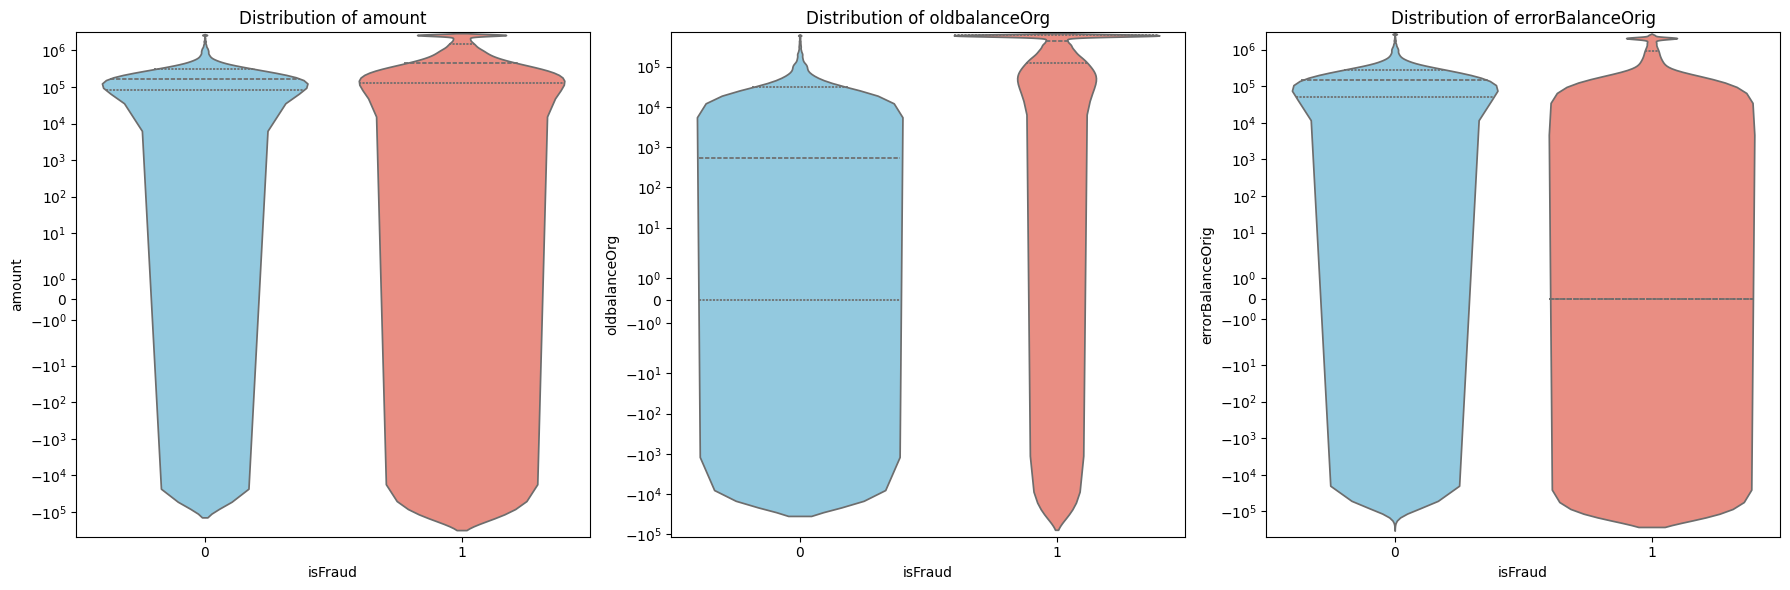

Generating 3D Scatter Plot...


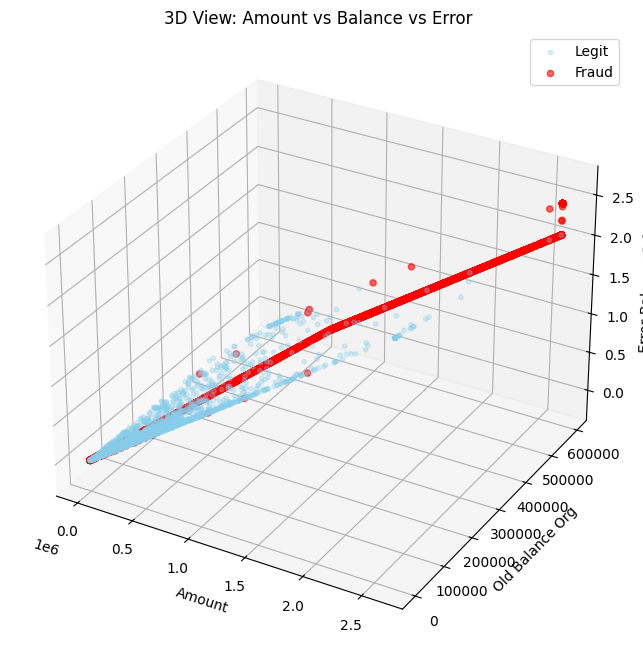

In [24]:
full_data = X.copy()
full_data['isFraud'] = Y

sample_fraud = full_data[full_data['isFraud'] == 1]
sample_legit = full_data[full_data['isFraud'] == 0].sample(n=5000, random_state=42)
plot_data = pd.concat([sample_fraud, sample_legit])

plot_data['isFraud'] = plot_data['isFraud'].astype(int)

print(f"\nPlotting data using a subset of {len(plot_data)} rows...")


# A. Pair Plot 

print("Generating Pair Plot...")
sns.pairplot(plot_data[['amount', 'oldbalanceOrg', 'errorBalanceOrig', 'isFraud']], 
             hue='isFraud', 
             palette={0: 'skyblue', 1: 'red'},
             plot_kws={'alpha': 0.6})
plt.suptitle("Pair Plot of Key Features", y=1.02)
plt.show()

# Violin Plots 

print("Generating Violin Plots...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

features = ['amount', 'oldbalanceOrg', 'errorBalanceOrig']

for i, col in enumerate(features):
    
    sns.violinplot(data=plot_data, x='isFraud', y=col, ax=axes[i], 
                   hue='isFraud', palette={0: 'skyblue', 1: 'salmon'}, 
                   inner="quart", legend=False)
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_yscale('symlog') 

plt.tight_layout()
plt.show()


# C. 3D Scatter Plot 

print("Generating 3D Scatter Plot...")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Ensure sample data matches the integer type
sample_legit_viz = plot_data[plot_data['isFraud'] == 0]
sample_fraud_viz = plot_data[plot_data['isFraud'] == 1]

ax.scatter(sample_legit_viz['amount'], sample_legit_viz['oldbalanceOrg'], sample_legit_viz['errorBalanceOrig'], 
           c='skyblue', label='Legit', alpha=0.3, s=10)
ax.scatter(sample_fraud_viz['amount'], sample_fraud_viz['oldbalanceOrg'], sample_fraud_viz['errorBalanceOrig'], 
           c='red', label='Fraud', alpha=0.6, s=20)

ax.set_xlabel('Amount')
ax.set_ylabel('Old Balance Org')
ax.set_zlabel('Error Balance Orig')
ax.set_title('3D View: Amount vs Balance vs Error')
ax.legend()
plt.show()

